In [1]:
import os
import mido
import random
import pretty_midi
import numpy as np
from rich.pretty import pprint
from glob import glob
from midi_player import MIDIPlayer
from midi_player.stylers import dark
import matplotlib.pyplot as plt

plt.style.use("dark_background")

In [2]:
TICKS_PER_BEAT = 220
random.seed(1)
dataset = os.path.join("..", "data", "datasets", "20250320", "segmented")
files = glob(os.path.join(dataset, "*.mid"))
pprint(files[:3])

[
│   '../data/datasets/20250320/segmented/20240926-065-01_0228-0236.mid',
│   '../data/datasets/20250320/segmented/20240305-050-05_0134-0143.mid',
│   '../data/datasets/20250320/segmented/20240126-050-04_0335-0345.mid'
]

In [3]:
random_file = random.choice(files)
# random_file = os.path.join(dataset, "20240126-050-04_0220-0230.mid")
mido.MidiFile(random_file).print_tracks()
MIDIPlayer(random_file, 300, styler=dark, title=os.path.basename(random_file))

=== Track 0
MetaMessage('set_tempo', tempo=1200000, time=0)
MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
MetaMessage('end_of_track', time=1760)
=== Track 1
MetaMessage('track_name', name='20240126-050-04_0220-0230', time=0)
Message('program_change', channel=0, program=0, time=0)
Message('note_on', channel=0, note=48, velocity=91, time=209)
Message('note_on', channel=0, note=48, velocity=0, time=16)
Message('note_on', channel=0, note=48, velocity=72, time=18)
Message('note_on', channel=0, note=48, velocity=0, time=11)
Message('note_on', channel=0, note=41, velocity=58, time=21)
Message('note_on', channel=0, note=41, velocity=0, time=18)
Message('note_on', channel=0, note=43, velocity=84, time=19)
Message('note_on', channel=0, note=43, velocity=0, time=16)
Message('note_on', channel=0, note=43, velocity=62, time=13)
Message('note_on', channel=0, note=43, velocity=0, time=19)
Message('note_on', channel=0, note=46, ve

In [4]:
def get_bpm(file_path: str) -> int:
    """
    Extracts the bpm from a MIDI file. First, extraction is attempted from the filename, then from the file itself. If there are multiple `set_tempo` messages,
    the last one is used. A time signature of 4/4 is assumed.

    Parameters
    ----------
    file_path : str
        Path to the MIDI file.

    Returns
    -------
    int
        The BPM. Default is 120 BPM if not explicitly set.
    """
    try:
        tempo = int(os.path.basename(file_path).split("-")[1])
    except ValueError:
        tempo = 120
        midi_file = mido.MidiFile(file_path)
        for track in midi_file.tracks:
            for message in track:
                if message.type == "set_tempo":
                    tempo = mido.tempo2bpm(message.tempo)

    return tempo

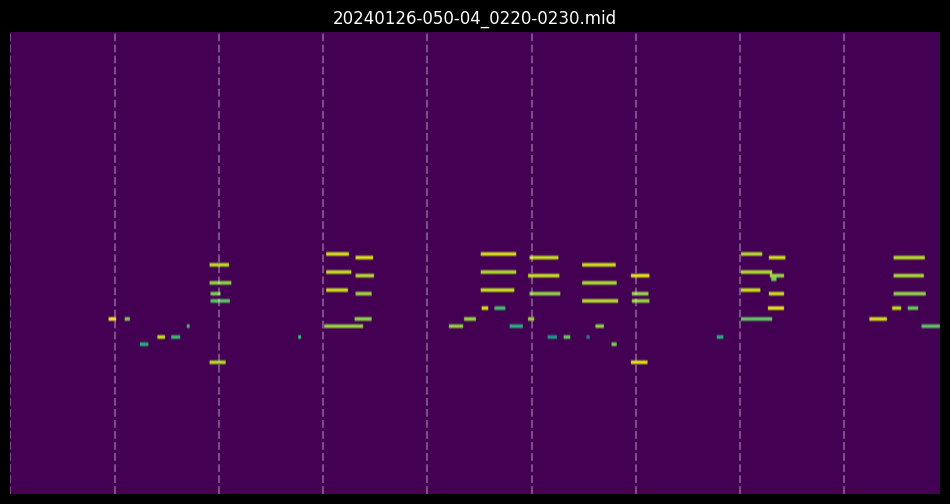

In [5]:
midi = pretty_midi.PrettyMIDI(random_file)
pr = midi.get_piano_roll(fs=int(TICKS_PER_BEAT * get_bpm(random_file) / 60))


plt.figure(figsize=(12, 6))
plt.title(f"{os.path.basename(random_file)}")
plt.imshow(pr, aspect="auto", origin="lower")

num_beats = int(pr.shape[1] / TICKS_PER_BEAT) + 1
for beat in range(num_beats):
    x = beat * TICKS_PER_BEAT
    plt.axvline(x=x, color="white", alpha=0.3, linestyle="--")

plt.axis("off")
plt.show()

In [6]:
def get_bpm(file_path: str) -> int:
    try:
        tempo = int(os.path.basename(file_path).split("-")[1])
    except ValueError:
        tempo = 120
        midi_file = mido.MidiFile(file_path)
        for track in midi_file.tracks:
            for message in track:
                if message.type == "set_tempo":
                    tempo = mido.tempo2bpm(message.tempo)

    return tempo


def beat_split(midi_path: str) -> dict:
    tempo = mido.bpm2tempo(get_bpm(midi_path))
    midi = pretty_midi.PrettyMIDI(midi_path)
    beat_timings = range(
        TICKS_PER_BEAT,
        mido.second2tick(midi.get_end_time(), TICKS_PER_BEAT, tempo) + TICKS_PER_BEAT,
        TICKS_PER_BEAT,
    )
    beats = {
        i: {
            "notes": [],
            "beats": [
                mido.MetaMessage(
                    "text",
                    text=f"beat {i}: {mido.tick2second(b - TICKS_PER_BEAT, TICKS_PER_BEAT, tempo):.1f}",
                    time=0,
                ),
                mido.MetaMessage(
                    "text",
                    text=f"beat {i+1}: {mido.tick2second(b, TICKS_PER_BEAT, tempo):.1f}",
                    time=TICKS_PER_BEAT,
                ),
            ],
        }
        for i, b in enumerate(beat_timings)
    }

    for instrument in midi.instruments:
        for note in instrument.notes:
            note_start_ticks = mido.second2tick(note.start, TICKS_PER_BEAT, tempo)

            for i, b in enumerate(beat_timings):
                if note_start_ticks < b:
                    note_offset = mido.tick2second(
                        b - TICKS_PER_BEAT, TICKS_PER_BEAT, tempo
                    )
                    note.start -= note_offset
                    note.end -= note_offset
                    beats[i]["notes"].append(note)
                    break

    return beats

In [7]:
split_beats = beat_split(random_file)
pprint(split_beats)

bpm = get_bpm(random_file)
for version, split in enumerate(split_beats.values()):
    pr = pretty_midi.PrettyMIDI(initial_tempo=bpm)
    new_inst = pretty_midi.Instrument(
        program=0, name=f"{os.path.basename(random_file).split('-')[0]}-{version}"
    )
    for note in split["notes"]:
        new_inst.notes.append(note)
    pr.instruments.append(new_inst)
    pr.write(f"data/split-{version}.mid")
mido.MidiFile("data/split-1.mid").print_tracks()

{
│   0: {
│   │   'notes': [Note(start=1.140000, end=1.227273, pitch=48, velocity=91)],
│   │   'beats': [
│   │   │   MetaMessage('text', text='beat 0: 0.0', time=0),
│   │   │   MetaMessage('text', text='beat 1: 1.2', time=220)
│   │   ]
│   },
│   1: {
│   │   'notes': [
│   │   │   Note(start=0.125455, end=0.185455, pitch=48, velocity=72),
│   │   │   Note(start=0.300000, end=0.398182, pitch=41, velocity=58),
│   │   │   Note(start=0.501818, end=0.589091, pitch=43, velocity=84),
│   │   │   Note(start=0.660000, end=0.763636, pitch=43, velocity=62),
│   │   │   Note(start=0.840000, end=0.872727, pitch=46, velocity=65),
│   │   │   Note(start=1.112727, end=1.227273, pitch=55, velocity=73),
│   │   │   Note(start=1.101818, end=1.287273, pitch=36, velocity=81),
│   │   │   Note(start=1.101818, end=1.325455, pitch=63, velocity=82),
│   │   │   Note(start=1.112727, end=1.336364, pitch=53, velocity=68),
│   │   │   Note(start=1.101818, end=1.352727, pitch=58, velocity=76)
│   │   ],
│   │   'beats': [
│   │   │   MetaMessage('text', text='beat 1: 1.2', time=0),
│   │   │   MetaMessage('text', text='beat 2: 2.4', time=220)
│   │   ]
│   },
│   2: {
│   │   'notes': [Note(start=0.927273, end=0.960000, pitch=43, velocity=64)],
│   │   'beats': [
│   │   │   MetaMessage('text', text='beat 2: 2.4', time=0),
│   │   │   MetaMessage('text', text='beat 3: 3.6', time=220)
│   │   ]
│   },
│   3: {
│   │   'notes': [
│   │   │   Note(start=0.049091, end=0.300000, pitch=56, velocity=84),
│   │   │   Note(start=0.049091, end=0.310909, pitch=66, velocity=85),
│   │   │   Note(start=0.049091, end=0.338182, pitch=61, velocity=83),
│   │   │   Note(start=0.027273, end=0.474545, pitch=46, velocity=77),
│   │   │   Note(start=0.376364, end=0.572727, pitch=48, velocity=76),
│   │   │   Note(start=0.387273, end=0.572727, pitch=55, velocity=78),
│   │   │   Note(start=0.387273, end=0.589091, pitch=65, velocity=86),
│   │   │   Note(start=0.387273, end=0.600000, pitch=60, velocity=81)
│   │   ],
│   │   'beats': [
│   │   │   MetaMessage('text', text='beat 3: 3.6', time=0),
│   │   │   MetaMessage('text', text='beat 4: 4.8', time=220)
│   │   ]
│   },
│   4: {
│   │   'notes': [
│   │   │   Note(start=0.261818, end=0.425455, pitch=46, velocity=76),
│   │   │   Note(start=0.436364, end=0.572727, pitch=48, velocity=77),
│   │   │   Note(start=0.638182, end=0.714545, pitch=51, velocity=86),
│   │   │   Note(start=0.785455, end=0.910909, pitch=51, velocity=64),
│   │   │   Note(start=0.627273, end=1.014545, pitch=56, velocity=83),
│   │   │   Note(start=0.627273, end=1.036364, pitch=61, velocity=80),
│   │   │   Note(start=0.627273, end=1.036364, pitch=66, velocity=85),
│   │   │   Note(start=0.960000, end=1.112727, pitch=46, velocity=58),
│   │   │   Note(start=1.172727, end=1.249091, pitch=48, velocity=77),
│   │   │   Note(start=1.189091, end=1.527273, pitch=65, velocity=83),
│   │   │   Note(start=1.172727, end=1.538182, pitch=60, velocity=83),
│   │   │   Note(start=1.189091, end=1.549091, pitch=55, velocity=76)
│   │   ],
│   │   'beats': [
│   │   │   MetaMessage('text', text='beat 4: 4.8', time=0),
│   │   │   MetaMessage('text', text='beat 5: 6.0', time=220)
│   │   ]
│   },
│   5: {
│   │   'notes': [
│   │   │   Note(start=0.201818, end=0.310909, pitch=43, velocity=49),
│   │   │   Note(start=0.387273, end=0.463636, pitch=43, velocity=70),
│   │   │   Note(start=0.649091, end=0.687273, pitch=43, velocity=37),
│   │   │   Note(start=0.752727, end=0.850909, pitch=46, velocity=76),
│   │   │   Note(start=0.600000, end=0.987273, pitch=63, velocity=84),
│   │   │   Note(start=0.938182, end=0.998182, pitch=41, velocity=73),
│   │   │   Note(start=0.600000, end=0.998182, pitch=58, velocity=79),
│   │   │   Note(start=0.600000, end=1.014545, pitch=53, velocity=81),
│   │   │   Note(start=1.161818, end=1.352727, pitch=36, velocity=87),
│   │   │   Note(start=1.172727, end=1.363636, pitch=55, velocity=77),
│   │   │   Note(start=1.172727, end=1.374545, 

=== Track 0
MetaMessage('set_tempo', tempo=1200000, time=0)
MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
MetaMessage('end_of_track', time=1)
=== Track 1
MetaMessage('track_name', name='20240126-1', time=0)
Message('program_change', channel=0, program=0, time=0)
Message('note_on', channel=0, note=48, velocity=72, time=23)
Message('note_on', channel=0, note=48, velocity=0, time=11)
Message('note_on', channel=0, note=41, velocity=58, time=21)
Message('note_on', channel=0, note=41, velocity=0, time=18)
Message('note_on', channel=0, note=43, velocity=84, time=19)
Message('note_on', channel=0, note=43, velocity=0, time=16)
Message('note_on', channel=0, note=43, velocity=62, time=13)
Message('note_on', channel=0, note=43, velocity=0, time=19)
Message('note_on', channel=0, note=46, velocity=65, time=14)
Message('note_on', channel=0, note=46, velocity=0, time=6)
Message('note_on', channel=0, note=36, velocity=81, time=42)


In [8]:
def beat_join(
    segments: dict[int, dict], arrangement: list[int], bpm: int
) -> pretty_midi.PrettyMIDI:
    segs_copy = segments
    beat_sec = 60 / bpm
    pm = pretty_midi.PrettyMIDI(initial_tempo=bpm)
    inst = pretty_midi.Instrument(
        program=0,
        name=f"{os.path.basename(random_file).split('-')[0]}_{''.join(map(str, arrangement))}",
    )
    for i, a in enumerate(arrangement):
        print(f"beat {i}: {a}")
        for note in segs_copy[a]["notes"]:
            new_note = pretty_midi.Note(
                velocity=note.velocity,
                pitch=note.pitch,
                start=note.start + i * beat_sec,
                end=note.end + i * beat_sec,
            )
            print(f"\t{note} -> {new_note}")
            inst.notes.append(new_note)
    pm.instruments.append(inst)

    return pm

In [9]:
fwd = [0, 1, 2, 3, 4, 5, 6, 7, 8]
rev = fwd[::-1]

beat_join(split_beats, fwd, get_bpm(random_file)).write("data/fwd.mid")
beat_join(split_beats, rev, get_bpm(random_file)).write("data/rev.mid")

beat 0: 0
	Note(start=1.140000, end=1.227273, pitch=48, velocity=91) -> Note(start=1.140000, end=1.227273, pitch=48, velocity=91)
beat 1: 1
	Note(start=0.125455, end=0.185455, pitch=48, velocity=72) -> Note(start=1.325455, end=1.385455, pitch=48, velocity=72)
	Note(start=0.300000, end=0.398182, pitch=41, velocity=58) -> Note(start=1.500000, end=1.598182, pitch=41, velocity=58)
	Note(start=0.501818, end=0.589091, pitch=43, velocity=84) -> Note(start=1.701818, end=1.789091, pitch=43, velocity=84)
	Note(start=0.660000, end=0.763636, pitch=43, velocity=62) -> Note(start=1.860000, end=1.963636, pitch=43, velocity=62)
	Note(start=0.840000, end=0.872727, pitch=46, velocity=65) -> Note(start=2.040000, end=2.072727, pitch=46, velocity=65)
	Note(start=1.112727, end=1.227273, pitch=55, velocity=73) -> Note(start=2.312727, end=2.427273, pitch=55, velocity=73)
	Note(start=1.101818, end=1.287273, pitch=36, velocity=81) -> Note(start=2.301818, end=2.487273, pitch=36, velocity=81)
	Note(start=1.101818

In [22]:
def remove_notes(
    midi_path: str, output_path: str, amount: int | float, num_versions: int = 1
) -> list[str]:
    """
    Remove notes from a MIDI file with intermediate versions.

    Parameters
    ----------
    midi_path : str
        Path to the input MIDI file.
    output_path : str
        Directory to save output files.
    amount : int | float
        Number or percentage of notes to remove.
    num_versions : int, optional
        Number of versions to create with the same amount of notes removed.

    Returns
    -------
    list[str]
        Paths to the new MIDI files.
    """
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    midi = pretty_midi.PrettyMIDI(midi_path)

    num_notes = 0
    for instrument in midi.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                num_notes += 1

    # change from percentage to absolute number
    if isinstance(amount, float) and amount < 1:
        amount = int(num_notes * amount)

    amount = int(amount)  # catch things like 1.3

    # determine intermediate steps for note removal
    steps = []
    if amount <= 3:
        # if removing 3 or fewer notes, just save the final version
        steps = [amount]
    else:
        # save up to 3 intermediate versions
        if amount % 2 == 1:  # odd
            steps = [
                1,
                amount // 2 + (amount % 4 > 0),
                amount,
            ]  # first, middle-ish, last
        else:  # even
            steps = [
                2,
                amount // 2 + (amount % 4 > 0),
                amount,
            ]  # first, middle-ish, last

    # Create a single random selection of indices to remove
    all_indices = np.random.permutation(range(num_notes))

    new_files = []
    for version in range(num_versions):
        for step in steps:
            notes_to_remove = all_indices[:step]
            print(f"removing {step}/{num_notes} notes: {notes_to_remove}")

            new_midi = pretty_midi.PrettyMIDI(
                initial_tempo=get_bpm(midi_path), resolution=TICKS_PER_BEAT
            )
            new_inst = pretty_midi.Instrument(program=0, name=f"{step}-{version}")
            for instrument in midi.instruments:
                if not instrument.is_drum:
                    for idx, note in enumerate(instrument.notes):
                        if idx not in notes_to_remove:
                            new_inst.notes.append(note)
            new_midi.instruments.append(new_inst)

            pf_new = os.path.join(
                output_path,
                f"{os.path.basename(midi_path).split('.')[0]}_{step:02d}-{version:02d}.mid",
            )
            print(f"writing '{pf_new}'")
            new_midi.write(pf_new)
            new_files.append(pf_new)

    return new_files

In [23]:
stripped_files = remove_notes(random_file, "data/stripped", 0.2)
print(stripped_files)
stripped_files = remove_notes(random_file, "data/stripped", 2)
print(stripped_files)

removing 2/61 notes: [51 52]
writing 'data/stripped/20240126-050-04_0220-0230_02-00.mid'
removing 6/61 notes: [51 52 33 37 49 41]
writing 'data/stripped/20240126-050-04_0220-0230_06-00.mid'
removing 12/61 notes: [51 52 33 37 49 41 59 55 22  7 31 15]
writing 'data/stripped/20240126-050-04_0220-0230_12-00.mid'
['data/stripped/20240126-050-04_0220-0230_02-00.mid', 'data/stripped/20240126-050-04_0220-0230_06-00.mid', 'data/stripped/20240126-050-04_0220-0230_12-00.mid']
removing 1/61 notes: [60]
writing 'data/stripped/20240126-050-04_0220-0230_01-00.mid'
['data/stripped/20240126-050-04_0220-0230_01-00.mid']


In [32]:
ids = list(range(9))

[ids[-2], ids[-1]] * 4

[7, 8, 7, 8, 7, 8, 7, 8]